In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

# Here starts my Baseline

Ideas:

1  - Feature engeneering- Basic and effective;

2 - Gradient Boosting Regressions;

3 - Neuronets Regressions; and

4 - Submission.



## 1 Feature Engeneering

In [2]:

def concat_df(df1, df2):
    df1 = pd.concat([df1, df2],
                    ignore_index=True, sort=False
                    ).drop_duplicates(["RowId"], keep="first")
    return df1

In [3]:
import gc

In [4]:
# For now... use pandas.... 
#If too heavy use Cudf

# For now... just fix the floats
dtypes = {
'SecuritiesCode' :     np.int16,
'Open'           :     np.float16,
'High'           :     np.float16,
'Low'            :     np.float16,
'Close'          :     np.float16,
'Volume'         :       np.int8,
'AdjustmentFactor':    np.float16,
'ExpectedDividend':    np.float16,
'Target'        :      np.float16
}
path = "../input/jpx-tokyo-stock-exchange-prediction/"
df_prices = pd.read_csv(f"{path}train_files/stock_prices.csv",dtype = dtypes)
#prices = pd.read_csv(f"{path}supplemental_files/stock_prices.csv",dtype = dtypes)
#df_prices = concat_df(df_prices, prices)
#prices = pd.read_csv(f"{path}train_files/secondary_stock_prices.csv",dtype = dtypes)
#df_prices = concat_df(df_prices, prices)
#prices = pd.read_csv(f"{path}supplemental_files/secondary_stock_prices.csv",dtype = dtypes)
#df_prices = concat_df(df_prices, prices)
df_prices = df_prices[df_prices.Date>"2021-11-01"]
df_prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44000 entries, 2288531 to 2332530
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowId             44000 non-null  object 
 1   Date              44000 non-null  object 
 2   SecuritiesCode    44000 non-null  int16  
 3   Open              43867 non-null  float16
 4   High              43867 non-null  float16
 5   Low               43867 non-null  float16
 6   Close             43867 non-null  float16
 7   Volume            44000 non-null  int8   
 8   AdjustmentFactor  44000 non-null  float16
 9   ExpectedDividend  55 non-null     float16
 10  SupervisionFlag   44000 non-null  bool   
 11  Target            44000 non-null  float16
dtypes: bool(1), float16(7), int16(1), int8(1), object(2)
memory usage: 1.8+ MB


In [5]:
# def prep_prices(price):
#     price.fillna(0,inplace=True)
#     return price

In [6]:
# df_prices = prep_prices(df_prices)
# pd.options.display.float_format = '{:,.6g}'.format
# df_prices.describe()

In [7]:
# # Open stock_list
# stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
# stock_list

In [8]:
# #Match Stocklist to securities code
# stock_list = stock_list[['SecuritiesCode','NewMarketSegment','33SectorCode','17SectorCode','Universe0','Section/Products','NewIndexSeriesSize']]
# stock_list = stock_list.replace(np.nan,'-')
# stock_list['Universe0'] = np.where(stock_list['Universe0'], 1, 0)
# stock_list = stock_list.drop_duplicates()
# stock_list


In [9]:
from datetime import datetime
import time

 # auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%Y-%m-%d").timetuple()))

# Data Features


In [48]:

# define function to compute log returns
def log_return_feature(series, periods=1):
    return np.log(series).diff(periods=periods)


# def fill_the_gaps(df):
#     new_df = pd.DataFrame(columns= df.columns)
#     for i in range(len(df['SecuritiesCode'].unique())):
#         new_df = new_df.append(df[df['SecuritiesCode'] == i].reindex(range(df[df['SecuritiesCode'] == i].index[0],df[df['SecuritiesCode'] == i].index[-1]+60,60),method='pad'))
#     new_df.fillna(method = 'pad', inplace = True) 
#     return new_df


def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi



def get_features(df):

    df['log_return_5'] = log_return_feature(df['Close'],periods=5)
    df['log_return'] = log_return_feature(df['Close'],periods=1)

    upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
    lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

    df['upper_shadow'] = upper_shadow(df)
    df['lower_shadow'] = lower_shadow(df)
    
#    df['EMA_21'] = df['Close'].ewm(span=21).mean()
    
#    df['EMA_55'] = df['Close'].ewm(span=55).mean()
    
# #     df['EMA_315'] = df['Close'].ewm(span=315).mean()
    
# #     df['EMA_825'] = df['Close'].ewm(span=825).mean()
    
#     window = 7
    
#     no_of_std = 2
    
#     df[f'EMA_{window}'] = df['Close'].ewm(span=window).mean()
    
#     df[f'EMA_{window}_std'] = df['Close'].rolling(window=window).std()
    
#     df[f'EMA_{window}_BB_high'] = df[f'EMA_{window}'] + no_of_std * df[f'EMA_{window}_std']
    
#     df[f'MA_{window}MA_BB_low'] = df[f'EMA_{window}'] - no_of_std * df[f'EMA_{window}_std']
    
#     window = 5
    
#     df[f'EMA_{window}'] = df['Close'].ewm(span=window).mean()
    
#     df[f'EMA_{window}_std'] = df['Close'].rolling(window=window).std()
    
#     df[f'EMA_{window}_BB_high'] = df[f'EMA_{window}'] + no_of_std * df[f'EMA_{window}_std']
    
#     df[f'MA_{window}MA_BB_low'] = df[f'EMA_{window}'] - no_of_std * df[f'EMA_{window}_std']
    
#     df['MACD'] = df['EMA_7'] - df['EMA_5']
    
    
#     df['rsi_5'] = rsiFunc(df['Close'].values, 5)
    
#     df['rsi_7'] = rsiFunc(df['Close'].values, 7)
    
#     df['rsi_21'] = rsiFunc(df['Close'].values, 21)
    
    
    
    df['VWAP'] = (df['Close'] * df['Volume'])/ df['Volume']




    
    
    #df = pd.concat([df, pd.get_dummies(df['Asset_ID'], prefix= 'Asset_')], axis=1)
    
    df[['log_return_5', 'log_return', 'upper_shadow', 'lower_shadow','VWAP']].astype('float16')
    
    return df



In [11]:
# scaled_features = ['Open', 'High', 'Low', 'Close', 'Volume','log_return_5', 'log_return', 'upper_shadow', 'lower_shadow',
#        'VWAP', 'EMA_7', 'EMA_7_std','EMA_7_BB_high', 'MA_7MA_BB_low', 'EMA_5', 'EMA_5_std', 'EMA_5_BB_high',
#        'MA_5MA_BB_low', 'MACD', 'rsi_5', 'rsi_7', 'rsi_21']
# features = ["SecuritiesCode",'Open', 'High', 'Low', 'Close', 'Volume', 'log_return_5', 'log_return', 'upper_shadow', 'lower_shadow',
#        'VWAP', 'EMA_7', 'EMA_7_std','EMA_7_BB_high', 'MA_7MA_BB_low', 'EMA_5', 'EMA_5_std', 'EMA_5_BB_high',
#        'MA_5MA_BB_low', 'MACD', 'rsi_5', 'rsi_7', 'rsi_21']

In [12]:
df_prices = df_prices.sort_values('SecuritiesCode')

df_prices = get_features(df_prices)

df_prices = df_prices.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

df_prices = df_prices.fillna(0)

/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1711: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = op(arr[res_indexer], arr[lag_indexer])


## Data Preparation



In [13]:

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

In [14]:
# # Creating endog and exog variables
# y = df_prices[['Target']]
# X = df_prices[features]

In [15]:
# X[scaled_features] = scaler.fit_transform(X[scaled_features])

## Training Model

From Keras tutorial:
https://keras.io/examples/structured_data/structured_data_classification_from_scratch/#preparing-the-data

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
val_dataframe = df_prices.sample(frac=0.2, random_state=1337)
train_dataframe = df_prices.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 35200 samples for training and 8800 for validation


In [18]:
del df_prices
gc.collect()

68

In [19]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

2022-06-22 01:58:44.001637: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
del train_dataframe
del val_dataframe
gc.collect()

23

In [21]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'RowId': <tf.Tensor: shape=(), dtype=string, numpy=b'20211203_4579'>, 'Date': <tf.Tensor: shape=(), dtype=string, numpy=b'2021-12-03'>, 'SecuritiesCode': <tf.Tensor: shape=(), dtype=int16, numpy=4579>, 'Open': <tf.Tensor: shape=(), dtype=float64, numpy=882.0>, 'High': <tf.Tensor: shape=(), dtype=float64, numpy=898.0>, 'Low': <tf.Tensor: shape=(), dtype=float64, numpy=875.0>, 'Close': <tf.Tensor: shape=(), dtype=float64, numpy=895.0>, 'Volume': <tf.Tensor: shape=(), dtype=int8, numpy=-96>, 'AdjustmentFactor': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>, 'ExpectedDividend': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'SupervisionFlag': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'log_return_5': <tf.Tensor: shape=(), dtype=float64, numpy=-0.03125>, 'log_return': <tf.Tensor: shape=(), dtype=float64, numpy=-0.01171875>, 'upper_shadow': <tf.Tensor: shape=(), dtype=float64, numpy=3.0>, 'lower_shadow': <tf.Tensor: shape=(), dtype=float64, numpy=7.0>, 'VWAP': <tf.Tensor: sh

In [22]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)


In [23]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [24]:
features = ["SecuritiesCode",'Open', 'High', 'Low', 'Close', 'Volume', 'log_return_5', 'log_return', 'upper_shadow', 'lower_shadow',
       'VWAP', 'EMA_7', 'EMA_7_std','EMA_7_BB_high', 'MA_7MA_BB_low', 'EMA_5', 'EMA_5_std', 'EMA_5_BB_high',
       'MA_5MA_BB_low', 'MACD', 'rsi_5', 'rsi_7']

In [25]:
#Categorical Features
SecuritiesCode = keras.Input(shape=(1,), name="SecuritiesCode", dtype="int16")

#Numerical Features
Open = keras.Input(shape=(1,), name="Open",dtype = 'float16')
High = keras.Input(shape=(1,), name="High",dtype = 'float16')
Low = keras.Input(shape=(1,), name="Low",dtype = 'float16')
Close = keras.Input(shape=(1,), name="Close",dtype = 'float16')
Volume = keras.Input(shape=(1,), name="Volume")
log_return_5 = keras.Input(shape=(1,), name="log_return_5",dtype = 'float16')
log_return = keras.Input(shape=(1,), name="log_return",dtype = 'float16')
upper_shadow = keras.Input(shape=(1,), name="upper_shadow",dtype = 'float16')
lower_shadow = keras.Input(shape=(1,), name="lower_shadow",dtype = 'float16')
VWAP = keras.Input(shape=(1,), name="VWAP",dtype = 'float16')
# EMA_7 = keras.Input(shape=(1,), name="EMA_7",dtype = 'float16')
# EMA_7_std = keras.Input(shape=(1,), name="EMA_7_std",dtype = 'float16')
# EMA_7_BB_high = keras.Input(shape=(1,), name="EMA_7_BB_high",dtype = 'float16')
# MA_7MA_BB_low = keras.Input(shape=(1,), name="MA_7MA_BB_low")
# EMA_5 = keras.Input(shape=(1,), name="EMA_5",dtype = 'float16')
# EMA_5_std = keras.Input(shape=(1,), name="EMA_5_std",dtype = 'float16')
# EMA_5_BB_high = keras.Input(shape=(1,), name="EMA_5_BB_high",dtype = 'float16')
# MA_5MA_BB_low = keras.Input(shape=(1,), name="MA_5MA_BB_low",dtype = 'float16')
# MACD = keras.Input(shape=(1,), name="MACD",dtype = 'float16')
# rsi_5 = keras.Input(shape=(1,), name="rsi_5",dtype = 'float16')
# rsi_7 = keras.Input(shape=(1,), name="rsi_7",dtype = 'float16')
# rsi_21 = keras.Input(shape=(1,), name="rsi_21",dtype = 'float16')

#imputs

all_inputs = [SecuritiesCode,Open, High, Low, Close, log_return_5,log_return, Volume, upper_shadow, lower_shadow,
       VWAP]

NameError: name 'f' is not defined

In [26]:


#Encode Numerical 
Open_encoded = encode_numerical_feature(Open, "Open", train_ds)
High_encoded = encode_numerical_feature(High, "High", train_ds)
Low_encoded = encode_numerical_feature(Low, "Low", train_ds)
Close_encoded = encode_numerical_feature(Close, "Close", train_ds)
Volume_encoded = encode_numerical_feature(Volume, "Volume", train_ds)
log_return_5_encoded = encode_numerical_feature(log_return_5, "log_return_5", train_ds)
log_return_encoded = encode_numerical_feature(log_return, "log_return", train_ds)
upper_shadow_encoded = encode_numerical_feature(upper_shadow, "upper_shadow", train_ds)
lower_shadow_encoded = encode_numerical_feature(lower_shadow, "lower_shadow", train_ds)
VWAP_encoded = encode_numerical_feature(VWAP, "VWAP", train_ds)
# EMA_7_encoded = encode_numerical_feature(EMA_7, "EMA_7", train_ds)
# EMA_7_std_encoded = encode_numerical_feature(EMA_7_std, "EMA_7_std", train_ds)
# EMA_7_BB_high_encoded = encode_numerical_feature(EMA_7_BB_high, "EMA_7_BB_high", train_ds)
# MA_7MA_BB_low_encoded = encode_numerical_feature(MA_7MA_BB_low, "MA_7MA_BB_low", train_ds)
# EMA_5_encoded = encode_numerical_feature(EMA_5, "EMA_5", train_ds)
# EMA_5_std_encoded = encode_numerical_feature(EMA_5_std, "EMA_5_std", train_ds)
# EMA_5_BB_high_encoded = encode_numerical_feature(EMA_5_BB_high, "EMA_5_BB_high", train_ds)
# MA_5MA_BB_low_encoded = encode_numerical_feature(MA_5MA_BB_low, "MA_5MA_BB_low", train_ds)
# MACD_encoded = encode_numerical_feature(MACD, "MACD", train_ds)
# rsi_5_encoded = encode_numerical_feature(rsi_5, "rsi_5", train_ds)
# rsi_7_encoded = encode_numerical_feature(rsi_7, "rsi_7", train_ds)


2022-06-22 01:58:56.473609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [32]:
# Encode Categorical
SecuritiesCode_encoded = encode_categorical_feature(SecuritiesCode, "SecuritiesCode", train_ds, False)

In [33]:
all_features = layers.concatenate(
    [SecuritiesCode_encoded,Open_encoded, High_encoded, Low_encoded, Close_encoded, Volume_encoded, log_return_5_encoded, log_return_encoded, upper_shadow_encoded, lower_shadow_encoded,
       VWAP_encoded
    ]
)


In [34]:
%%time

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

CPU times: user 48.9 ms, sys: 830 µs, total: 49.7 ms
Wall time: 52.8 ms


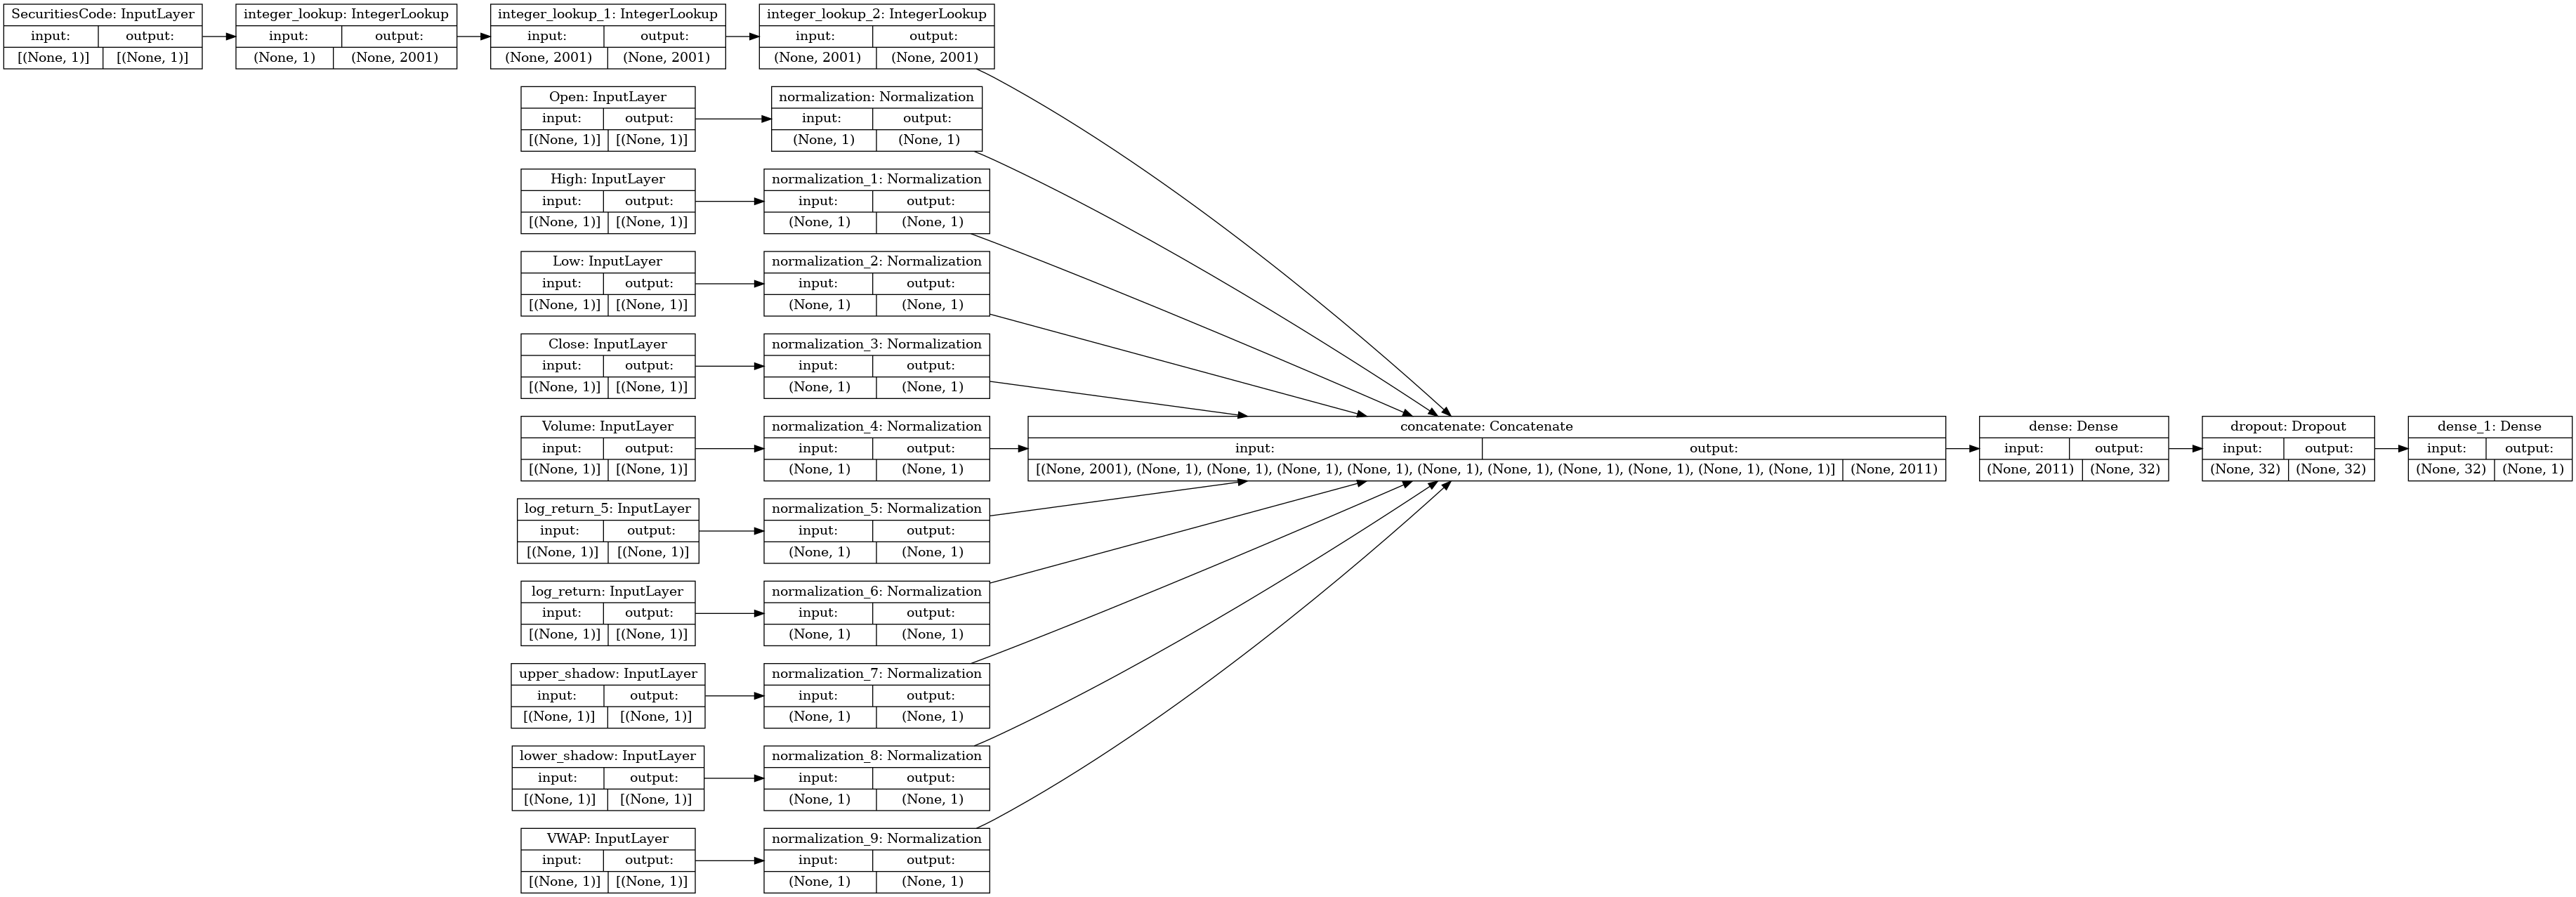

In [35]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [36]:
# Set early_stopping callbacks, if val_loss does not improve for 10 epochs, stop training and restore best model weights
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-3,
    restore_best_weights=True,
)

In [37]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['RowId', 'Date', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


1100/1100 [==============================] - 14s 12ms/step - loss: 0.0471 - accuracy: 0.0331 - val_loss: -0.0147 - val_accuracy: 0.0324
Epoch 2/50
1100/1100 [==============================] - 13s 11ms/step - loss: -0.0259 - accuracy: 0.0331 - val_loss: -0.0365 - val_accuracy: 0.0324
Epoch 3/50
1100/1100 [==============================] - 13s 11ms/step - loss: -0.0619 - accuracy: 0.0331 - val_loss: -0.0888 - val_accuracy: 0.0324
Epoch 4/50
1100/1100 [==============================] - 13s 11ms/step - loss: -0.1384 - accuracy: 0.0331 - val_loss: -0.1851 - val_accuracy: 0.0324
Epoch 5/50
1100/1100 [==============================] - 13s 11ms/step - loss: -0.2605 - accuracy: 0.0331 - val_loss: -0.3201 - val_accuracy: 0.0324
Epoch 6/50
1100/1100 [==============================] - 13s 11ms/step - loss: -0.4252 - accuracy: 0.0331 - val_loss: -0.4941 - val_accuracy: 0.0324
Epoch 7/50
1100/1100 [==============================] - 13s 12ms/step - loss: -0.6311 - accuracy: 0.0331 - val_loss: -0.7006

In [39]:
# Save model
model.save("spx_toy_model.tf")

2022-06-22 02:16:10.958507: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Submission


In [40]:
# Load trained model
best_model = keras.models.load_model("spx_toy_model.tf")

In [41]:
# Generate tensorflow dataset for test data
def dataframe_to_dataset_test(dataframe):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    return ds

In [42]:
import jpx_tokyo_market_prediction


# Make predictions and submission
env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    prices = prices.sort_values('SecuritiesCode')
    prices = get_features(prices)
    prices = prices.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    prices = prices.fillna(0)
    test_ds = dataframe_to_dataset_test(prices)
    sample_prediction['target_pred'] = best_model.predict(test_ds)
    sample_prediction = sample_prediction.sort_values(by="target_pred", ascending=False)
    sample_prediction['Rank'] = np.arange(2000)
    sample_prediction = sample_prediction.sort_values(by="SecuritiesCode", ascending=True)
    sample_prediction.drop(['target_pred'], axis=1, inplace=True)
    display(sample_prediction)
    env.predict(sample_prediction)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:185 assert_input_compatibility
        (name, list(inputs.keys()), names))

    ValueError: Missing data for input "log_return_5". You passed a data dictionary with keys ['Date', 'RowId', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag']. Expected the following keys: ['SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'log_return_5', 'log_return', 'Volume', 'upper_shadow', 'lower_shadow', 'VWAP']


In [49]:
prices = prices.sort_values('SecuritiesCode')
prices = get_features(prices)
prices = prices.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
prices = prices.fillna(0)

In [51]:
test_ds = dataframe_to_dataset_test(prices)

In [52]:
sample_prediction['target_pred'] = best_model.predict(test_ds)

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['AdjustmentFactor', 'Date', 'ExpectedDividend', 'RowId', 'SupervisionFlag'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:415 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/layers/merge.py:178 call
        return self._merge_function(inputs)
    /opt/conda/lib/python3.7/site-packages/keras/layers/merge.py:518 _merge_function
        return backend.concatenate(inputs, axis=self.axis)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/backend.py:3069 concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1769 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:1228 concat_v2
        "ConcatV2", values=values, axis=axis, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:601 _create_op_internal
        compute_device)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3569 _create_op_internal
        op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2042 __init__
        control_input_ops, op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 1 but is rank 2 for '{{node model/concatenate/concat}} = ConcatV2[N=11, T=DT_FLOAT, Tidx=DT_INT32](model/integer_lookup_2/bincount/DenseBincount, model/normalization/truediv, model/normalization_1/truediv, model/normalization_2/truediv, model/normalization_3/truediv, model/normalization_4/truediv, model/normalization_5/truediv, model/normalization_6/truediv, model/normalization_7/truediv, model/normalization_8/truediv, model/normalization_9/truediv, model/concatenate/concat/axis)' with input shapes: [2001], [1,1], [1,1], [1,1], [1,1], [1,1], [1,1], [1,1], [1,1], [1,1], [1,1], [].
